In [75]:
import shutil
import os
import numpy as np
import pandas as pd
import random
import time

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, roc_auc_score, auc, precision_recall_curve, roc_curve, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2


from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

%matplotlib inline 

In [76]:
def load_data_to_df(path, path_indice : int=8):
    imgs = []
    paths = []
    breed  = []
    height, width = [], []

    for folder in tqdm(glob(os.path.abspath(path)), desc="Loading data ... : "):
        img = cv2.imread(folder)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        paths.append(folder)
        height.append(img.shape[0])
        width.append(img.shape[1])
        breed.append(folder.split("/")[path_indice].split("-", 1)[1])
    df = pd.DataFrame({'img' : imgs, 'path': paths, 'breed': breed, 'height': height, 'width': width})
    return df

def copy_img(split_df, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for i, path in tqdm(split_df["path"].items()):
        label_folder = os.path.join(folder, split_df.loc[i, "breed"])
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        image_name = path.split(os.path.sep)[-1]
        destination = os.path.join(label_folder, image_name)
        shutil.copy(path, destination)

In [77]:
def plot_height_x_width(df, dataset: str):
    f, ax = plt.subplots(2, 1, figsize=(12, 12))
    ax[0].scatter(df.height, df.width, s=1)
    ax[0].set_xlabel('Height', fontsize=16)
    ax[0].set_ylabel('Width', fontsize=16)
    ax[0].set_title(f'Scatter Plot of Height and Width of dog {dataset} images')

    ax[1].hist(df.height, bins=50, alpha=0.5)
    ax[1].hist(df.width, bins=50, alpha=0.5)
    ax[1].axis([0, 1000, 0, 2000])
    ax[1].set_xlabel('Height/Width', fontsize=16)
    ax[1].set_ylabel('Num of Images', fontsize=16)
    ax[1].set_title(f'Variation of image sizes within {dataset} dataset')
    plt.show()

def grey_picture_plot(df):
    img_path = df["path"].values[0]
    f, ax = plt.subplots(2, 1, figsize=(12, 12))
    img = cv2.imread(img_path,0)
    imgfull = cv2.imread(img_path)
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist,bins = np.histogram(img.ravel(),256,[0,256])
    ax[0].hist(img.ravel(),256,[0,256])
    ax[0].set_title(f'Variation of image of black & white')
    ax[1].imshow(img, cmap = 'gray', interpolation = 'bicubic')
    ax[1].set_title(f'One channel image')
    f.suptitle(f"Breed : {df['breed'].values[0]}")
    plt.show()

def dist_breed(df, dataset :str):
    breed_df = df.copy()
    n_classes = len(breed_df['breed'].unique())

    breed_df['freq'] = breed_df.groupby('breed')['breed'].transform('count')
    avg = breed_df.freq.mean()

    title = f'Distribution of Dog Breeds in {dataset} Dataset\n ({avg:3.0f} samples per class on average)'
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.set_xticks([])

    ax.hlines(avg, 0, n_classes - 1, color='white')
    ax.set_title(title, fontsize=18)
    _ = ax.hist(breed_df['breed'], bins=n_classes)
    print("-"*100, f"Distribution for {dataset}", breed_df["freq"].describe(), "-"*100, sep="\n")

def img_histogram(df):
    img_path = df["path"].values[0]
    f, ax = plt.subplots(2, 1, figsize=(12, 12))
    img = cv2.imread(img_path)
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        ax[0].plot(histr, color=col)
        ax[0].set_xlim([0,256])
        ax[0].set_title(f"Distribution of RGB")
    ax[1].imshow(Image.open(img_path).convert('RGB'))
    ax[1].set_title(f"Shape of the image : {img.shape}")
    f.suptitle(f"Breed : {df['breed'].values[0]}")
    plt.show()

def display_img(df):
    img_path = df['path'].values[0]
    print(f"Breed : {df['breed'].values[0]}")
    imgplot = Image.open(img_path)
    return imgplot

In [78]:
DATA_ROOT_DIR = '../dataset/Images/*/*'

In [79]:
df = load_data_to_df(DATA_ROOT_DIR)
df['breed'] = df['breed'].str.lower().str.replace("_", " ")

Loading data ... :   0%|          | 0/20580 [00:00<?, ?it/s]

In [80]:
df.shape

(20580, 5)

In [81]:
df.head()

img  \
0  [[[251, 255, 252], [105, 111, 107], [84, 90, 8...   
1  [[[196, 138, 225], [196, 138, 225], [195, 137,...   
2  [[[106, 87, 57], [106, 87, 57], [108, 87, 58],...   
3  [[[49, 49, 49], [43, 43, 43], [39, 39, 39], [4...   
4  [[[219, 194, 164], [221, 196, 166], [223, 198,...   

                                                path          breed  height  \
0  /home/alex/Bureau/OpenClassroom/projet_6/datas...  saint bernard     480   
1  /home/alex/Bureau/OpenClassroom/projet_6/datas...  saint bernard     333   
2  /home/alex/Bureau/OpenClassroom/projet_6/datas...  saint bernard     500   
3  /home/alex/Bureau/OpenClassroom/projet_6/datas...  saint bernard     375   
4  /home/alex/Bureau/OpenClassroom/projet_6/datas...  saint bernard     282   

   width  
0    393  
1    500  
2    333  
3    500  
4    290

Breed : clumber


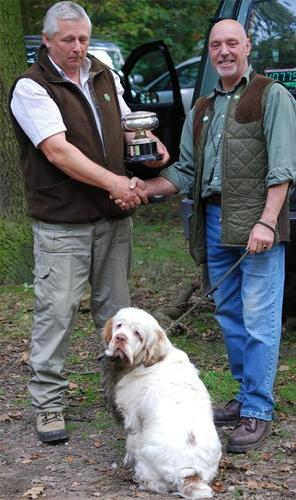

In [82]:
display_img(df.sample(1))

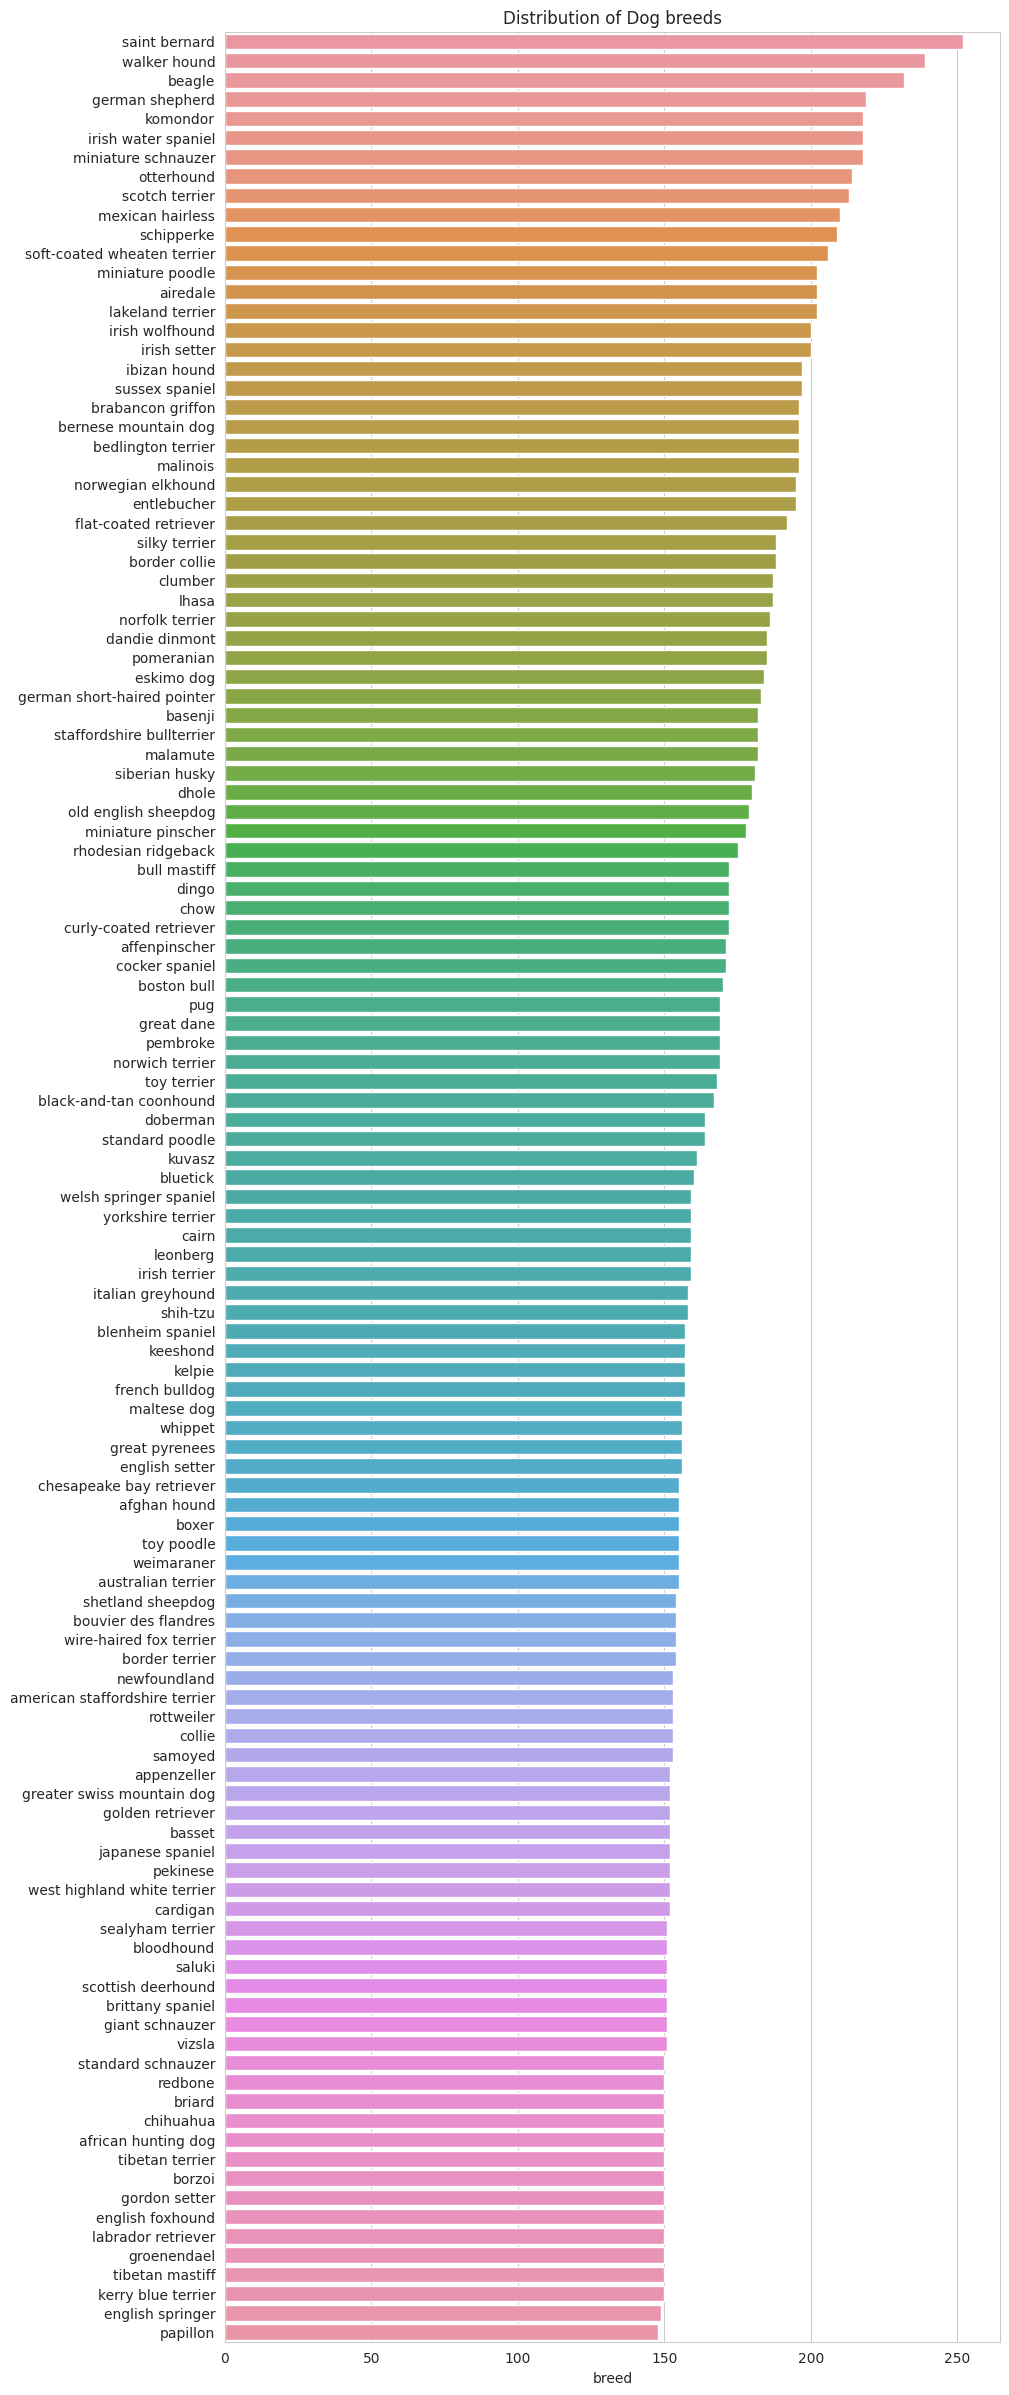

In [83]:
fig, ax = plt.subplots(figsize=(10,30))
ax.set_title('Distribution of Dog breeds')
sns.barplot(data=df, x=df["breed"].value_counts(), y=df["breed"].unique(), ax=ax)
plt.show()

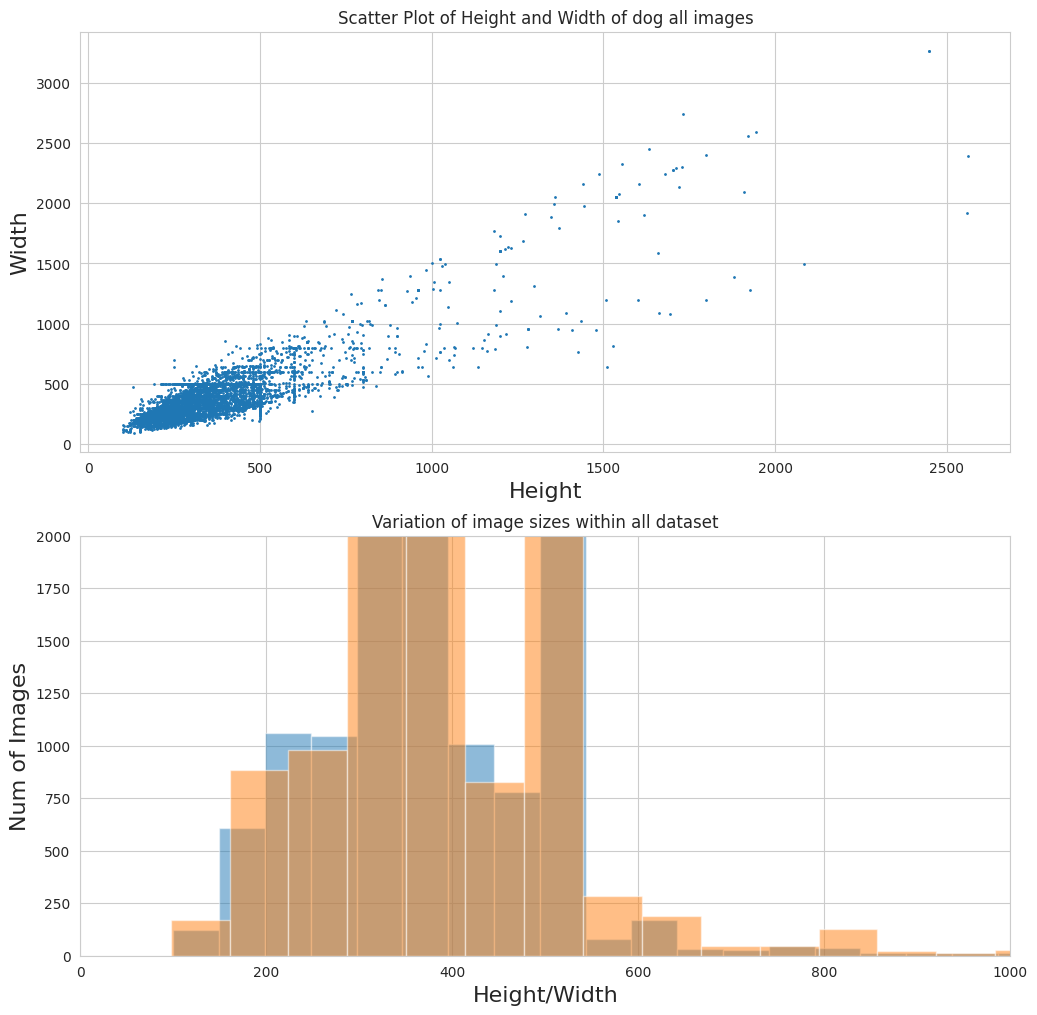

In [84]:
plot_height_x_width(df, "all")

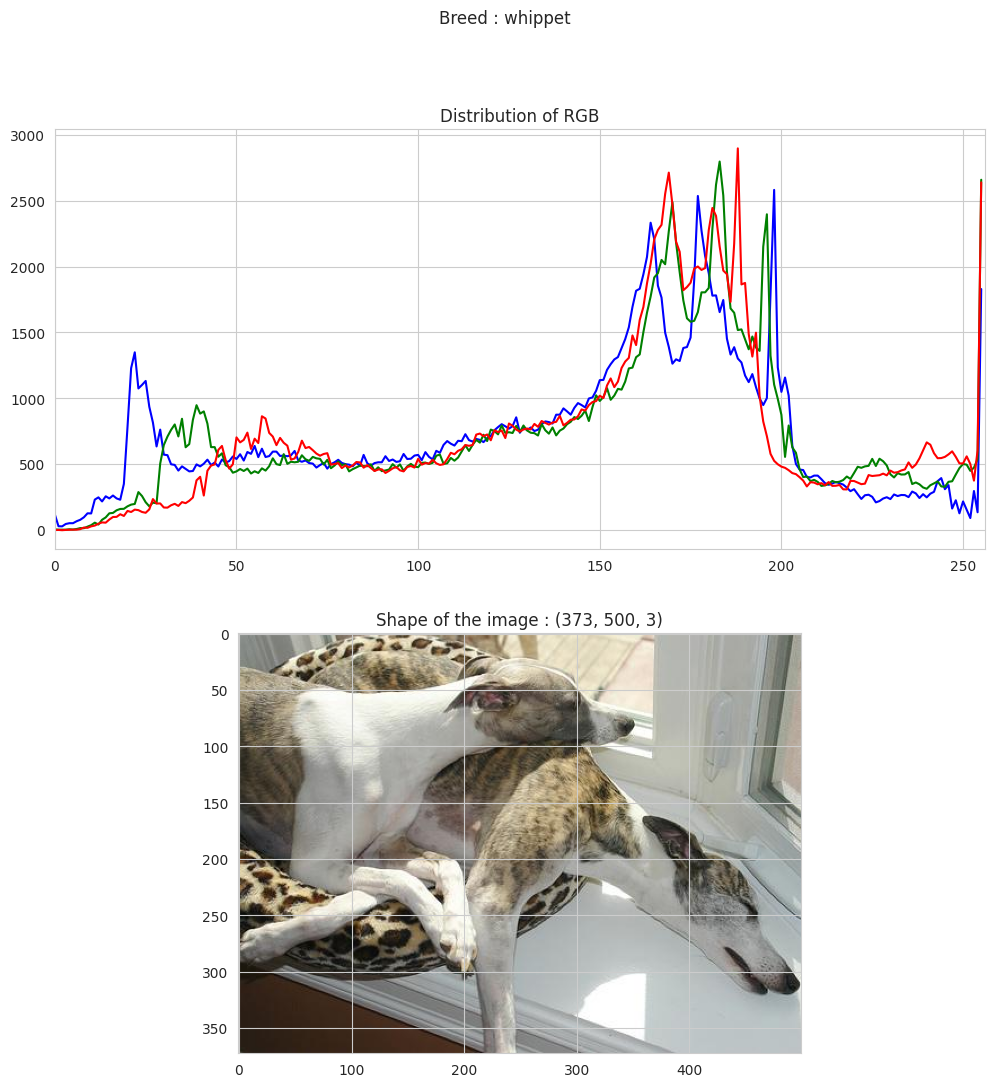

In [85]:
img_histogram(df.sample(1))

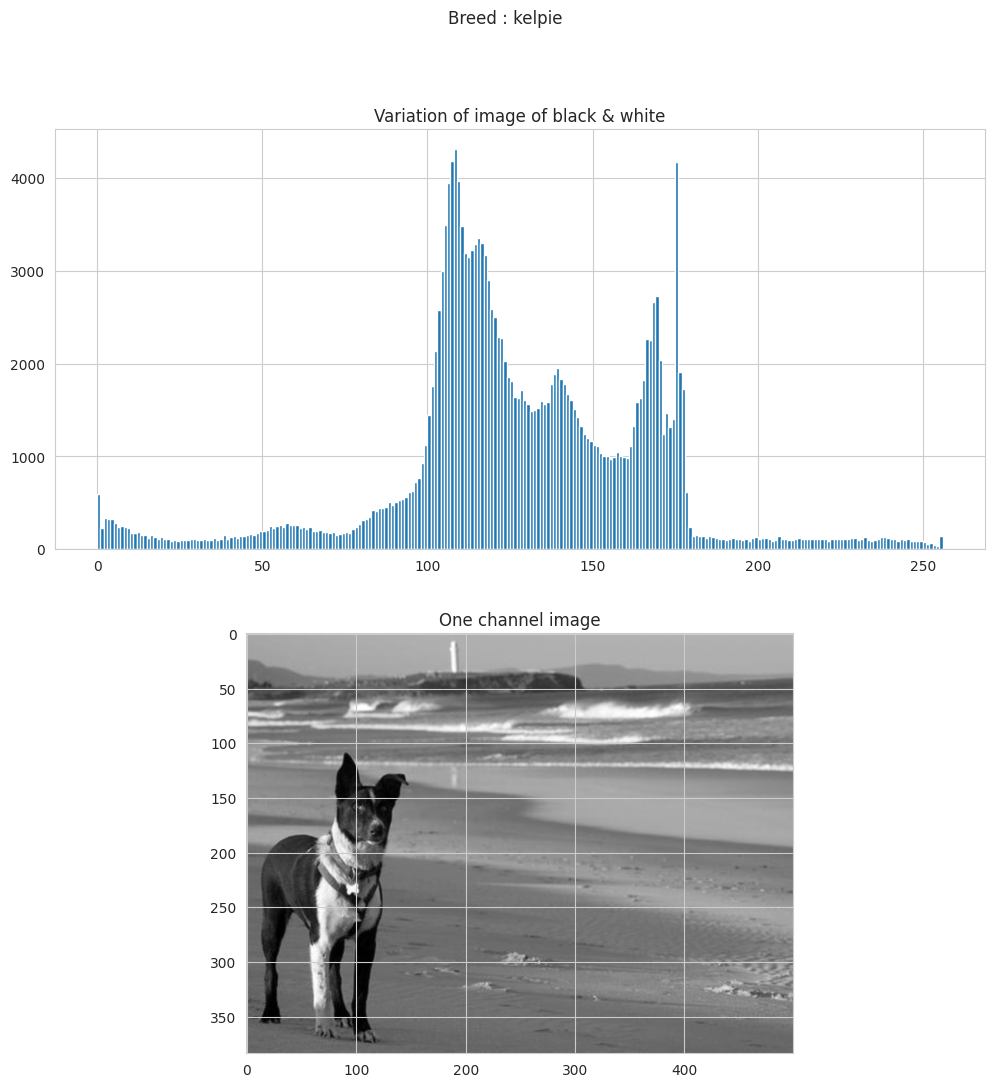

In [86]:
grey_picture_plot(df.sample(1))

In [87]:
seed = 42

In [88]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [89]:
def split_df(df, rs : int=seed):
    Xy = df[["path", "breed"]]
    train, test = train_test_split(
        Xy, test_size=0.2, random_state=rs, stratify=df['breed'])
    train, valid = train_test_split(
        train, test_size=0.1, random_state=rs, stratify=train['breed'])
    return train, test, valid

In [90]:
train_df, test_df, valid_df = split_df(df)

In [101]:

def map_class(df):
    idx2label = {id:key for id, key in enumerate(df["breed"].unique())}
    label2idx = {key:id for id, key in enumerate(df["breed"].unique())}
    return idx2label, label2idx

idx2label    = {id:key for id, key in enumerate(df["breed"].unique())}
label2idx = {key:id for id, key in enumerate(df["breed"].unique())}
class StanfordDogDataset(Dataset):
    def __init__(self, ds, class_map=label2idx, transform=None, calc_mean=False):
        self.images_filepaths = ds["path"].to_list()
        self.label = ds["breed"].to_list()
        self.label_map = class_map
        self.transform = transform
        self.calc_mean = calc_mean

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]

        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.calc_mean:
            image = Image.open(image_filepath)
            if image.mode == "RGBA":
                # One picture is in 4 channels when open with PIL ??????? but not with openCV
                image = Image.open(image_filepath).convert("RGB")
        class_id = self.label_map[self.label[idx]]
        # class_id = torch.tensor(class_id)

        if self.transform is not None:
            image = self.transform(image=image)["image"] if not self.calc_mean else self.transform(image)

        return image, class_id

In [102]:
# dist_breed(train_df, "train")

In [103]:
# plot_height_x_width(train_df, "train")

In [104]:
# dist_breed(test_df, "test")

In [105]:
# plot_height_x_width(test_df, "test")

In [106]:
# dist_breed(valid_df, "validation")

In [107]:
# plot_height_x_width(valid_df, "validation")

In [108]:
# random_idx = np.random.randint(1, len(train_df), size=9)
# fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# for idx, ax in enumerate(axes.ravel()):
#     img = Image.open(train_list[idx])
#     ax.set_title(labels[idx])
#     ax.imshow(img)

In [109]:

def plot_image_augmentations_albumentations(df):
    sample = df.sample(1)
    aug =  [
        A.Resize(width=512, height=512),
        A.RandomCrop(width=300, height=300),
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
        A.Blur(blur_limit=3, p=0.5),
        # A.OneOf([
        #     A.Blur(blur_limit=3, p=0.5),
        #     A.ColorJitter(p=0.5),
        # ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        A.ColorJitter(p=0.5),
    ]
    n_images = len(aug)
    classes = sample["breed"].values[0]
    image = sample["img"].values[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    print(rows, cols, n_images)
    fig = plt.figure(figsize = (25, 25))
    fig.suptitle(f"Dog breed : {classes}")
    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        show_transforms = A.Compose([
            aug[i],
        ])

        transformed = show_transforms(image=image)
        transformed_image = transformed["image"]

        ax.imshow(transformed_image)
        ax.set_title(aug[i].__class__.__name__)

        ax.axis('off')


In [110]:
mean_std = StanfordDogDataset(ds=train_df, transform=transforms.ToTensor(), calc_mean=True)

def calculate_means_std(tranformed_dataset):
    means = torch.zeros(3)
    stds = torch.zeros(3)

    for img, label in tqdm(tranformed_dataset):
        means += torch.mean(img, dim = (1,2))
        stds += torch.std(img, dim = (1,2))

    means /= len(mean_std)
    stds /= len(mean_std)

    print(f'Calculated means: {means}')
    print(f'Calculated stds: {stds}')
    return means, stds

means, stds = calculate_means_std(mean_std)

  0%|          | 0/14817 [00:00<?, ?it/s]

Calculated means: tensor([0.4768, 0.4529, 0.3919])
Calculated stds: tensor([0.2334, 0.2287, 0.2269])


3 3 9


ValueError: Requested crop size (300, 300) is larger than the image size (281, 410)

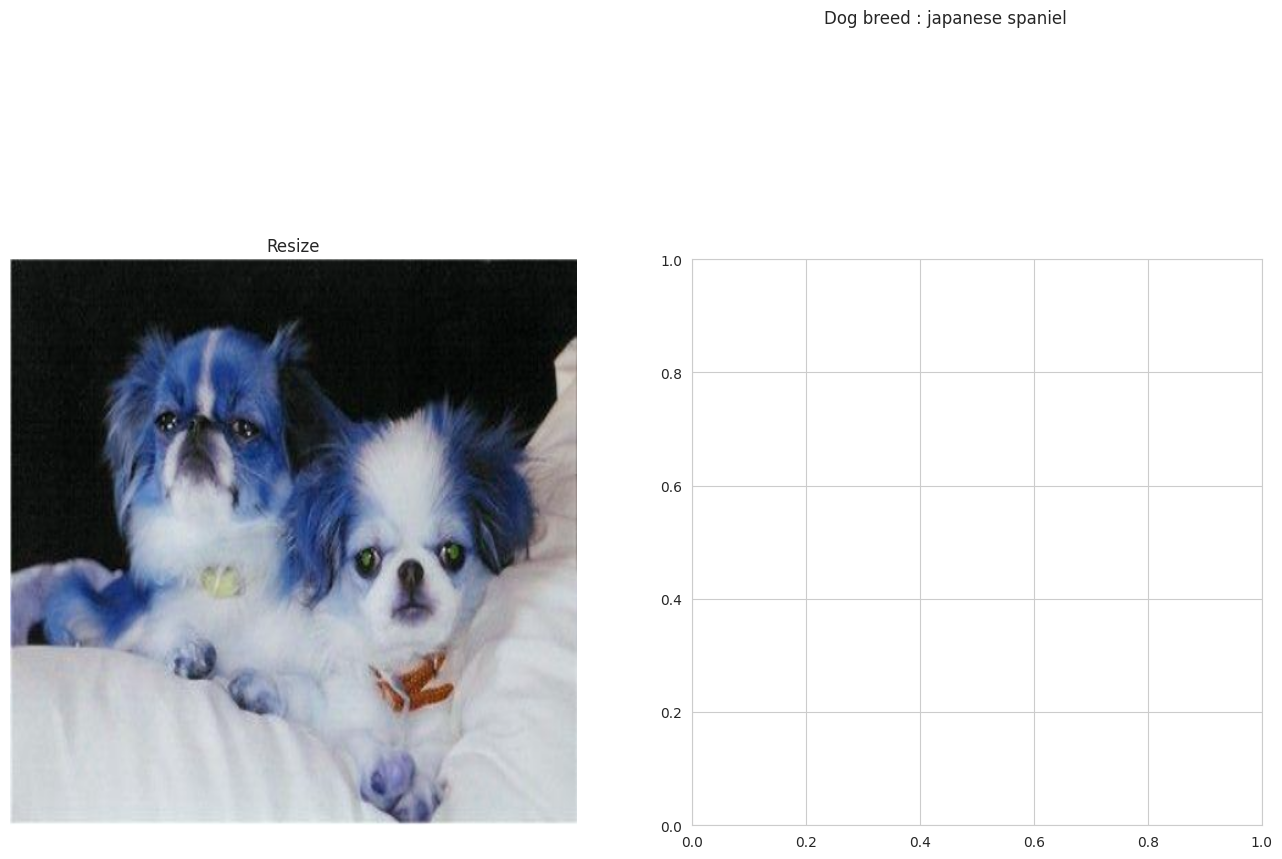

In [111]:
plot_image_augmentations_albumentations(df)

## Modèlisation 

In [ ]:
def plot_training(train_data, model_name):
    df_res = pd.DataFrame(train_data, columns=["train_loss", "train_acc", "valid_loss", "valid_acc"])
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].plot(df_res.train_loss, label='train')
    ax[0].plot(df_res.valid_loss, label='valid')
    ax[0].set_title(f'Training / validation loss')
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)

    ax[1].plot(df_res.train_acc, label='train')
    ax[1].plot(df_res.valid_acc, label='valid')
    ax[1].set_title(f'Training / validation accuracy')
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)

    plt.legend()
    fig.savefig(f'{model_name}.png', dpi=fig.dpi)
    plt.show()
    
    return df_res

def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            # y_pred, _ = model(x)
            y_pred = model(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d',
            cmap='Blues',
            ax=ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)
    plt.tight_layout()
    plt.show()

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label.item()]
        incorrect_class = classes[incorrect_label.item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)
    plt.show()
    
def plot_gradcam(incorrect, classes, n_images, model, target_layers):


    cam = GradCAM(model=model, target_layers=[target_layers], use_cuda=True)



    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        grayscale_cam = cam(input_tensor=image.unsqueeze(0))
        grayscale_cam = grayscale_cam[0, :]

        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label.item()]
        incorrect_class = classes[incorrect_label.item()]


        image = normalize_image(image)
        visualization = show_cam_on_image(image.cpu().numpy(), grayscale_cam, use_rgb=True)
        

        ax.imshow(visualization)
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)
    plt.show()
    

In [112]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [113]:
# Training transforms.
def train_transforms(img_size):
    train_transform = A.Compose(

        [     A.Resize(width=img_size, height=img_size),
              A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.1),
              A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
              A.OneOf([
                  A.Blur(blur_limit=3, p=0.5),
                  A.ColorJitter(p=0.5),
              ], p=1.0),
              A.Normalize(
                  mean=means,
                  std=stds,
                  max_pixel_value=255,
              ),
              ToTensorV2(),
              ]
    )


    return train_transform

# Validation transforms.
def valid_transforms(img_size):
    valid_transform = A.Compose(
        [
            A.Resize(width=img_size, height=img_size),
            # A.SmallestMaxSize(max_size=160),
            # A.CenterCrop(height=128, width=128),
            A.Normalize(mean=means, std=stds),
            ToTensorV2(),
        ]
    )
    return valid_transform


def get_datasets(img_size):
    train_dataset = StanfordDogDataset(ds=train_df, transform=train_transforms(img_size))
    val_dataset = StanfordDogDataset(ds=valid_df, transform=valid_transforms(img_size))
    test_dataset = StanfordDogDataset(ds=test_df, transform=valid_transforms(img_size))
    return (
        train_dataset, val_dataset, 
        test_dataset
    )

def get_data_loaders(
    train_dataset, valid_dataset, test_dataset,
    batch_size, num_workers):
    
    train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        
        num_workers=num_workers, pin_memory=True
    )
    return train_loader, val_loader, test_loader

# Custom CNN model 

In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [115]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=120):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 9 * 9)
        x = self.classifier(x)
        return x

In [116]:
params = {
    "model": "custom-cnn-model",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

In [117]:
custom_model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(custom_model.parameters(), lr=params["lr"], momentum=0.9)

In [118]:
img_size = 32 

In [119]:
train_dataset, val_dataset, test_dataset = get_datasets(img_size)

In [124]:
train_dataset[0][0].size()

torch.Size([3, 32, 32])

In [120]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(val_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 14817
Number of validation examples: 1647
Number of testing examples: 4116


In [121]:
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, 
                                                         batch_size=params["batch_size"], num_workers=params["num_workers"])

In [131]:
len(next(iter(train_loader)))

2

In [122]:
if os.path.isfile(f'./{params["model"]}.pt'):
    custom_model.load_state_dict(torch.load(f'./{params["model"]}.pt'))              
else:
    EPOCHS = 30

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(custom_model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(custom_model, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            # torch.save(model.state_dict(), f'{params["model"]}.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    df_res = pd.DataFrame(train_data, columns=["train_loss", "train_acc", "valid_loss", "valid_acc"])
    plot_training(df_res, params["model"])

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 4.778 | Train Acc: 1.13%
	 Val. Loss: 4.745 |  Val. Acc: 2.58%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 4.703 | Train Acc: 2.00%
	 Val. Loss: 4.606 |  Val. Acc: 2.82%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 4.606 | Train Acc: 2.49%
	 Val. Loss: 4.541 |  Val. Acc: 2.52%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 4.559 | Train Acc: 2.86%
	 Val. Loss: 4.490 |  Val. Acc: 2.94%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 4.516 | Train Acc: 3.37%
	 Val. Loss: 4.422 |  Val. Acc: 3.79%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 4.472 | Train Acc: 3.41%
	 Val. Loss: 4.382 |  Val. Acc: 5.05%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 4.431 | Train Acc: 4.12%
	 Val. Loss: 4.335 |  Val. Acc: 5.30%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def get_metrics(test_data, prediction):
    precision = round(precision_score(test_data, prediction, average='micro'), 2)
    recall = round(recall_score(test_data, prediction, average='micro'), 2)

    accuracy = round(accuracy_score(test_data, prediction), 2)
    f1 = round(f1_score(test_data, prediction, average='micro'), 2)
    report = classification_report(test_data, prediction, output_dict=True)

    df = pd.DataFrame(report).transpose()
    print(f"precision: {precision}, recall: {recall}, F1-measure: {f1}, accuracy : {accuracy}")
    print(classification_report(test_data, prediction))
    print(df.sort_values(by="f1-score"))


In [ ]:
images, labels, probs = get_predictions(custom_model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
y_preds = [idx2label[idx] for idx in pred_labels.tolist()]
y_true = [idx2label[idx] for idx in labels.tolist()]

In [ ]:
get_metrics(y_true, y_preds)

# VGG training

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim=120):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        # return x, h
        return x


vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [ ]:
img_size = 224 

train_dataset, val_dataset, test_dataset = get_datasets(img_size)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, 
                                                         batch_size=params["batch_size"], num_workers=params["num_workers"])

In [ ]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(val_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

In [ ]:
params = {
    "model": "custom-vgg-model",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 16,
    "num_workers": 1,
    "epochs": 10,
}

In [ ]:

vgg_model = VGG(vgg11_layers).to(device)
optimizer = optim.Adam(vgg_model.parameters(), lr=params["lr"])

# optimizer = torch.optim.SGD(vgg_model.parameters(), lr=params["lr"], momentum=0.9)

criterion = nn.CrossEntropyLoss().to(device)

criterion = criterion.to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(vgg_model):,} trainable parameters')

In [ ]:
if os.path.isfile(f'{params["model"]}.h5'):
    vgg_model.load_state_dict(torch.load(f'{params["model"]}.h5'))              
else:
    
    EPOCHS = 10

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(vgg_model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(vgg_model, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(vgg_model.state_dict(), f'{params["model"]}.h5')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    df_res = pd.DataFrame(train_data, columns=["train_loss", "train_acc", "valid_loss", "valid_acc"])
    
    plot_training(df_res, params["model"])

In [ ]:
images, labels, probs = get_predictions(vgg_model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
y_preds = [idx2label[idx] for idx in pred_labels.tolist()]
y_true = [idx2label[idx] for idx in labels.tolist()]

In [ ]:
get_metrics(y_true, y_preds)

In [ ]:
plot_confusion_matrix(labels, pred_labels, idx2label)

In [ ]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, idx2label, N_IMAGES)

In [ ]:
plot_gradcam(incorrect_examples, idx2label, N_IMAGES, vgg_model, vgg_model.features[-1])

# Transfer learning (ResNet model)

In [ ]:
params = {
    "model": "resnet50-transfer_learning",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 16,
    "num_workers": 1,
    "epochs": 10,
}

In [ ]:
img_size = 224 

train_dataset, val_dataset, test_dataset = get_datasets(img_size)

In [ ]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(val_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, 
                                                         batch_size=params["batch_size"], num_workers=params["num_workers"])

In [ ]:
pretrained_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT
                                   )

In [ ]:
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = len(idx2label)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc

In [ ]:
optimizer = optim.Adam(pretrained_model.parameters(), lr= 1e-3)

criterion = nn.CrossEntropyLoss()

pretrain_model = pretrained_model.to(device)
criterion = criterion.to(device)

In [ ]:
if os.path.isfile(f'{params["model"]}.pt'):
    pretrained_model.load_state_dict(torch.load(f'{params["model"]}.pt'))              
else:
    
    EPOCHS = 10

    best_valid_loss = float('inf')
    train_data = []
    for epoch in trange(EPOCHS, desc="Epochs"):

        start_time = time.monotonic()

        train_loss, train_acc = train(pretrained_model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(pretrained_model, val_loader, criterion, device)
        train_data.append([train_loss, train_acc, valid_loss, valid_acc])
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(pretrained_model.state_dict(), f'{params["model"]}.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    df_res = pd.DataFrame(train_data, columns=["train_loss", "train_acc", "valid_loss", "valid_acc"])
    
    plot_training(df_res, params["model"])

In [ ]:
images, labels, probs = get_predictions(pretrain_model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
y_preds = [idx2label[idx] for idx in pred_labels.tolist()]
y_true = [idx2label[idx] for idx in labels.tolist()]

In [ ]:
get_metrics(y_true, y_preds)

In [ ]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)


In [ ]:
len(incorrect_examples)

In [ ]:
# img_super = []
# target_layers = [pretrain_model.layer4[-1]]


# cam = GradCAM(model=pretrain_model, target_layers=target_layers, use_cuda=True)


# grayscale_cam = cam(input_tensor=incorrect_examples[0][0].unsqueeze(0))
# grayscale_cam = grayscale_cam[0, :]
# # img = Image.fromarray(x.cpu().numpy(), 'RGB')
# rgb_img = normalize_image(i)
# visualization = show_cam_on_image(rgb_img.cpu().numpy(), grayscale_cam, use_rgb=True)
# print(visualization)
# img_super.append(visualization)

# i = incorrect_examples[0][0].permute(1, 2, 0)

# # i = normalize_image(image
# #                )
# # i = Image.fromarray(image.cpu().numpy(), 'RGB')

# # tensor_to_pil = transforms.ToPILImage()(incorrect_examples[0][0].unsqueeze(0))
# # print(tensor_to_pil.size)
# i.cpu().numpy()
# plt.imshow(i)
# img = Image.fromarray(img_super[0], 'RGB')
# img

In [ ]:
# img_super = []
# target_layers = [pretrain_model.layer4[-1]]


# cam = GradCAM(model=pretrain_model, target_layers=target_layers, use_cuda=True)

# with torch.enable_grad():

#     for (x, y) in test_loader:

#         x = x.to(device)
#         print(x.size())
#         # y_pred, _ = model(x)
#         # y_pred = pretrain_model(x)
#         # y_prob = F.softmax(y_pred, dim=-1)
#         grayscale_cam = cam(input_tensor=x)
#         grayscale_cam = grayscale_cam[0, :]
#         img = Image.fromarray(x.cpu().numpy(), 'RGB')
#         visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
#         img_super.append(visualization)


# Optimizing hyperparameters (Ray tune)

In [ ]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:

# For scheduler
MAX_NUM_EPOCHS = 10
GRACE_PERIOD = 1

# Training parameters.
EPOCHS = 10
# Data root.

NUM_WORKERS = 2

# For search run.
CPU = 1
GPU = 1
NUM_SAMPLES = 10

# img_size = 224

num_classes = 120

In [ ]:
# # Training transforms.
# def train_transforms():
#     img_size = 224 

#     train_transform = A.Compose(

#         [     A.Resize(width=img_size, height=img_size),
#               A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
#               A.HorizontalFlip(p=0.5),
#               A.VerticalFlip(p=0.1),
#               A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
#               A.OneOf([
#                   A.Blur(blur_limit=3, p=0.5),
#                   A.ColorJitter(p=0.5),
#               ], p=1.0),
#               A.Normalize(
#                   mean=means,
#                   std=stds,
#                   max_pixel_value=255,
#               ),
#               ToTensorV2(),
#               ]

#     )


#     return train_transform

# # Validation transforms.
# def valid_transforms(img_size):
#     valid_transform = A.Compose(
#         [
#             A.Resize(width=img_size, height=img_size),
#             # A.SmallestMaxSize(max_size=160),
#             # A.CenterCrop(height=128, width=128),
#             A.Normalize(mean=means, std=stds),
#             ToTensorV2(),
#         ]
#     )
#     return valid_transform

# def get_datasets():
#     train_dataset = StanfordDogDataset(ds=train_df, transform=train_transforms)
#     val_dataset = StanfordDogDataset(ds=valid_df, transform=valid_transforms)
#     test_dataset = StanfordDogDataset(ds=test_df, transform=valid_transforms)
#     classes = []
#     return (
#         train_dataset, val_dataset, 
#         test_dataset, classes
#     )

# def get_data_loaders(
#     train_dataset, valid_dataset, test_dataset,
#     BATCH_SIZE, NUM_WORKERS):
    
#     train_loader = data.DataLoader(
#     train_dataset, batch_size=NUM_WORKERS, shuffle=True,
#         num_workers=NUM_WORKERS, pin_memory=True
#     )

#     test_loader = data.DataLoader(
#         test_dataset, batch_size=params["batch_size"], shuffle=False,
#         num_workers=NUM_WORKERS, pin_memory=True
#     )
#     val_loader = data.DataLoader(
#         val_dataset, batch_size=params["batch_size"], shuffle=False,
        
#         num_workers=NUM_WORKERS, pin_memory=True
#     )
#     return train_loader, val_loader, test_loader

In [ ]:
 # Training function.
def train_optim(model, data_loader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(data_loader):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs, x = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(data_loader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate_optim(model, data_loader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs, x = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(data_loader.dataset))
    return epoch_loss, epoch_acc

# Function to carry out testing.
def test_optim(model, data_loader, device):
    counter = 0
    test_running_correct = 0.
    with torch.no_grad():
        for i, data in tqdm(enumerate(data_loader), total=len(data_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs, x = model(image)
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete test set.
    acc = 100. * (test_running_correct / len(data_loader.dataset))
    return acc

In [ ]:
def train_and_validate(config):
    # Get all the datasets
    (
        train_dataset, valid_dataset, test_dataset
    ) = get_datasets(224)
    print(f"[INFO]: Number of training samples: {len(train_dataset)}")
    print(f"[INFO]: Number of validation samples: {len(valid_dataset)}")
    print(f"[INFO]: Number of test samples: {len(test_dataset)}")
    # Get training and validation data loaders,
    # ignore test data loader for now.
    train_loader, valid_loader, _ = get_data_loaders(
        train_dataset, valid_dataset, test_dataset,
        config['batch_size'], NUM_WORKERS
    )

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Initialize the model
    model = pretrain_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), lr=config['lr']
    )

    # start the training
    for epoch in range(EPOCHS):
        print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
        train_epoch_loss, train_epoch_acc = train_optim(
            model, train_loader, optimizer, criterion, device
        )
        valid_epoch_loss, valid_epoch_acc = validate_optim(
            model, valid_loader, criterion, device
        )
  
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-'*50)

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        tune.report(
            loss=valid_epoch_loss, accuracy=valid_epoch_acc
        )

def run_search():
    # Define the parameter search configuration.
    config = {
        # "first_conv_out":
        #     tune.sample_from(lambda _: 2 ** np.random.randint(4, 8)),
        # "first_fc_out": tune.sample_from(lambda _: 2 ** np.random.randint(4, 12)),
        "lr": tune.loguniform(1e-5, 1e-2),
        "batch_size": tune.choice([8, 16, 32]),
        # "img_trans" : tune.choice([
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomVerticalFlip(p=0.5),
        # transforms.RandomCrop(img_size, padding=2),
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        # transforms.RandomRotation(degrees=(30, 70)),
        # ])
    }

    # Schduler to stop bad performing trails.
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=MAX_NUM_EPOCHS,
        grace_period=GRACE_PERIOD,
        reduction_factor=2)

    # Reporter to show on command line/output window
    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])
    # Start run/search
    result = tune.run(
        train_and_validate,
        resources_per_trial={"cpu": CPU, "gpu": GPU},
        config=config,
        num_samples=NUM_SAMPLES,
        scheduler=scheduler,
        local_dir='raytune_result',
        keep_checkpoints_num=1,
        checkpoint_score_attr='accuracy',
        progress_reporter=reporter
    )
    # Extract the best trial run from the search.
    best_trial = result.get_best_trial(
        # 'accuracy', 'max', 'last'
        'loss', 'min', 'last'
    )
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation acc: {best_trial.last_result['accuracy']}")

    # Carry out the final testing with the best settings.
    device = 'cuda:0'
    train_dataset, valid_dataset, test_dataset = get_datasets(224
    )
    _, _, test_loader = get_data_loaders(
        train_dataset, valid_dataset, test_dataset, 
        best_trial.config['batch_size'], NUM_WORKERS
    )
    print('[INFO]: Building best model for testing...')
    best_model = pretrain_model.to(device)
    best_checkpoint_dir = best_trial.checkpoint.value
    print('[INFO]: Loading best model weights...')
    model_state, optimizer_state = torch.load(
        os.path.join(best_checkpoint_dir, 'checkpoint')
    )
    best_model.load_state_dict(model_state)
    test_acc = test_optim(best_model, test_loader, device)
    print(f"[INFO]: Test results from the best trained model: {test_acc:.3f}")




# best_trial = result.get_best_trial("loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(
#     best_trial.last_result["loss"]))
# print("Best trial final validation accuracy: {}".format(
#     best_trial.last_result["accuracy"]))

# best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
# device = "cpu"
# if torch.cuda.is_available():
#     device = "cuda:0"
#     if gpus_per_trial > 1:
#         best_trained_model = nn.DataParallel(best_trained_model)
# best_trained_model.to(device)
#
# best_checkpoint_dir = best_trial.checkpoint.value
# model_state, optimizer_state = torch.load(os.path.join(
#     best_checkpoint_dir, "checkpoint"))
# best_trained_model.load_state_dict(model_state)
#
# test_acc = test_accuracy(best_trained_model, device)
# print("Best trial test set accuracy: {}".format(test_acc))
# if __name__ == '__main__':





# run_search()

# Testing loading on 1000 k classes imagnenet 

In [ ]:
vit = models.vit_b_16(
    weights='ViT_B_16_Weights.IMAGENET1K_V1'
).to(device)

In [ ]:
_, _, test_dataset = get_datasets(img_size=224)
_, _, test_loader = get_data_loaders(_, _, test_dataset, 1, 1)

In [ ]:
def imagenet1k(model, test_loader, test_df):
    data = []
    model.eval()
    for (x ,y) in tqdm(test_loader):
        out = model(x.to(device))
        with open('./imageNet_1000_classes.txt') as f:
            labels = [line.strip() for line in f.readlines()]

        _, index = torch.max(out, 1)

        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
        data.append(labels[index[0]])
        _, indices = torch.sort(out, descending=True)
        [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]
    df_res = pd.DataFrame()
    df_res["breed"] = test_df["breed"]
    df_res["pred"] = data
    df_res["pred"] = df_res["pred"].str.split(",").str[0].str.lower()
    print(accuracy_score(df_res["breed"], df_res["pred"]))

In [ ]:
imagenet1k(vit, test_loader, test_df)

In [ ]:
# vit_1k = []


# # test_dataset = StanfordDogDataset(ds=test_df, transform=test_trans)

# vit.eval()
# for (x ,y) in tqdm(test_loader):
#     out = vit(x.to(device))
#     with open('./imageNet_1000_classes.txt') as f:
#         labels = [line.strip() for line in f.readlines()]

#     _, index = torch.max(out, 1)

#     percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

#     # print(labels[index[0]], percentage[index[0]].item())
#     vit_1k.append(labels[index[0]])
#     _, indices = torch.sort(out, descending=True)
#     [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

In [ ]:
t, i, y = get_predictions(vit, test_loader, device)

In [ ]:
t